In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
   'train': transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ]),
   'val': transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ]),
}

batch_size = 8

data_dir = '/scratch/users/chiuh/cs432'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print unique labels in training set
train_labels = [label for _, label in image_datasets['train']]
print(f"Unique labels in train set: {np.unique(train_labels)}")

# Print unique labels in validation set
val_labels = [label for _, label in image_datasets['val']]
print(f"Unique labels in validation set: {np.unique(val_labels)}")

Unique labels in train set: [0 1]
Unique labels in validation set: [0 1]


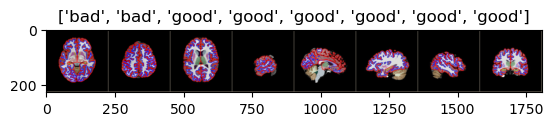

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

def plot_roc_curve(fpr, tpr, auc, title='ROC Curve'):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []  # Initialize list for training losses
    val_losses = []    # Initialize list for validation losses
    train_labels = []  # Initialize list for training labels
    train_preds = []   # Initialize list for training predictions
    val_labels = []    # Initialize list for validation labels
    val_preds = []     # Initialize list for validation predictions

    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                # Gather predictions during training
                if phase == 'train':
                    train_labels.extend(labels.cpu().numpy())
                    train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy()[:, 1])
                elif phase == 'val':
                    val_labels.extend(labels.cpu().numpy())
                    val_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy()[:, 1])

                # Append the loss to the respective list
                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Return additional information for plotting
    return model, train_losses, val_losses, train_labels, train_preds, val_labels, val_preds

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft, train_losses, val_losses, train_labels, train_preds, val_labels, val_preds = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7603 Acc: 0.7057
val Loss: 0.6051 Acc: 0.7898

Epoch 1/24
----------
train Loss: 0.6551 Acc: 0.7429
val Loss: 0.5859 Acc: 0.7808

Epoch 2/24
----------
train Loss: 0.6426 Acc: 0.7429
val Loss: 0.5679 Acc: 0.7898

Epoch 3/24
----------
train Loss: 0.6622 Acc: 0.7543
val Loss: 0.6226 Acc: 0.7838

Epoch 4/24
----------
train Loss: 0.7054 Acc: 0.7171
val Loss: 0.6039 Acc: 0.7868

Epoch 5/24
----------
train Loss: 0.6694 Acc: 0.7200
val Loss: 0.5936 Acc: 0.7928

Epoch 6/24
----------
train Loss: 0.6599 Acc: 0.7429
val Loss: 0.5814 Acc: 0.7898

Epoch 7/24
----------
train Loss: 0.6721 Acc: 0.7400
val Loss: 0.5735 Acc: 0.7898

Epoch 8/24
----------
train Loss: 0.6538 Acc: 0.7429
val Loss: 0.5812 Acc: 0.7808

Epoch 9/24
----------
train Loss: 0.6391 Acc: 0.7486
val Loss: 0.6116 Acc: 0.7838

Epoch 10/24
----------
train Loss: 0.6588 Acc: 0.7457
val Loss: 0.5923 Acc: 0.7928

Epoch 11/24
----------
train Loss: 0.6957 Acc: 0.7314
val Loss: 0.5893 Acc: 0.7868

Ep

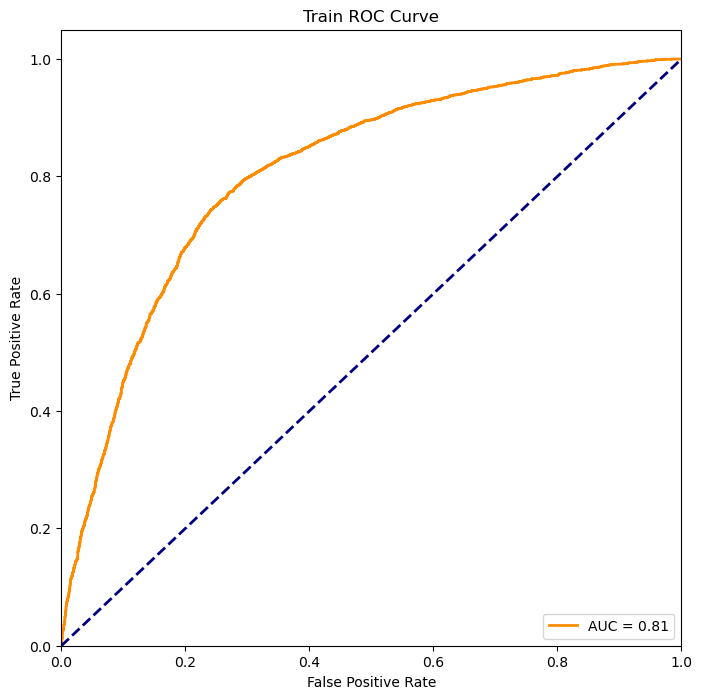

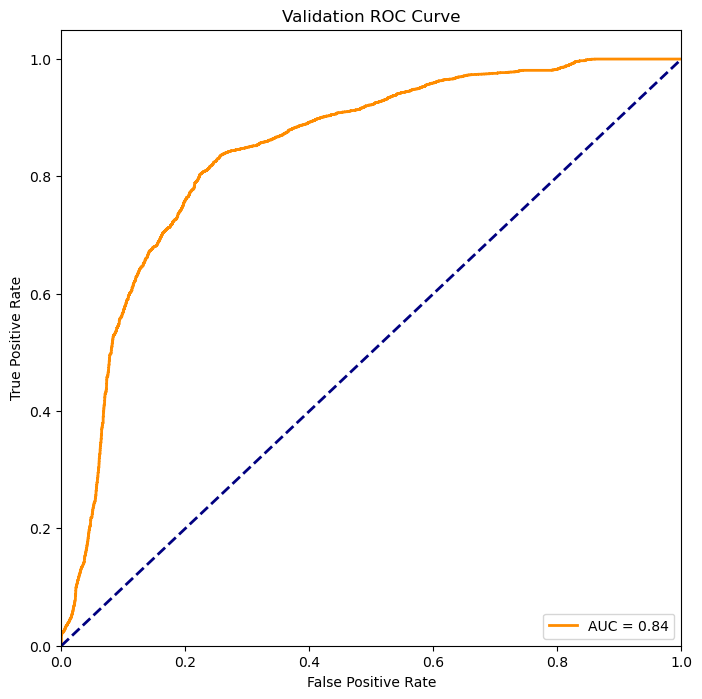

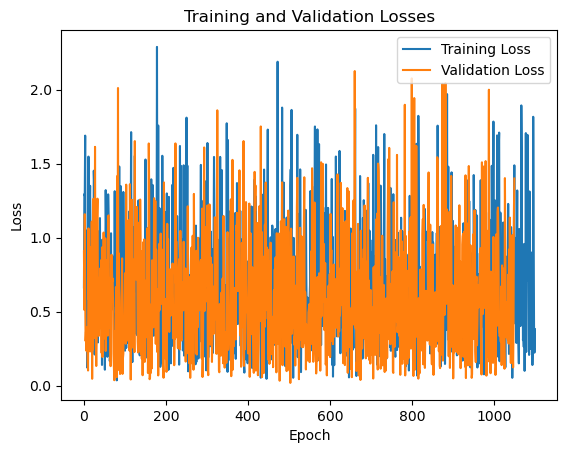

In [8]:
# Compute ROC-AUC and plot ROC curve
train_auc = roc_auc_score(train_labels, train_preds)
val_auc = roc_auc_score(val_labels, val_preds)

fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_preds)

plot_roc_curve(fpr_train, tpr_train, train_auc, title='Train ROC Curve')
plot_roc_curve(fpr_val, tpr_val, val_auc, title='Validation ROC Curve')

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.show()

Unique labels in train set: [0 1]
Unique labels in validation set: [0 1]


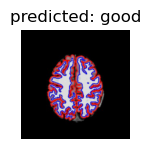

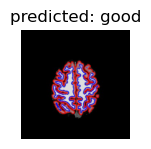

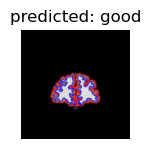

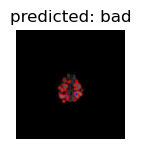

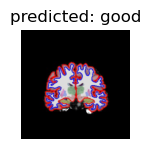

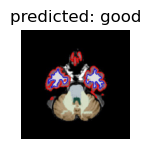

In [9]:
# After the for loop for 'train' and 'val' phases in the train_model function
print(f"Unique labels in train set: {np.unique(train_labels)}")
print(f"Unique labels in validation set: {np.unique(val_labels)}")

visualize_model(model_ft)

In [10]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
model_vgg = models.vgg19_bn(weights='IMAGENET1K_V1')

# Get the number of input features for the fully connected layer
num_ftrs = model_vgg.classifier[6].in_features

# Modify the fully connected layer to match the number of classes in your problem (here assumed as 2)
model_vgg.classifier[6] = nn.Linear(num_ftrs, 2)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)

# try adam which may also help with overfitting, but less clear compared to data augmentation and dropout

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [6]:
model_vgg, train_losses, val_losses, train_labels, train_preds, val_labels, val_preds = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler,
                       num_epochs=25)

#Save the model (you can include this step in the training loop to save the best model during training.)
# torch.save(model_vgg.state_dict(), f"vgg19bn_model.pth")
# print(f"Saved PyTorch Model State to vgg19bn_model.pth")

#torch.save((loss,val_loss),f"vgg19bn_losses.pt")
# print(f"Saved Losses to vgg19bn_losses.pt")

Epoch 0/24
----------
train Loss: 1.2044 Acc: 0.5629
val Loss: 0.7742 Acc: 0.7027

Epoch 1/24
----------
train Loss: 1.0267 Acc: 0.5829
val Loss: 0.8017 Acc: 0.6787

Epoch 2/24
----------
train Loss: 1.0320 Acc: 0.6057
val Loss: 0.8473 Acc: 0.6697

Epoch 3/24
----------
train Loss: 1.0721 Acc: 0.6143
val Loss: 0.8415 Acc: 0.6697

Epoch 4/24
----------
train Loss: 1.0498 Acc: 0.6029
val Loss: 0.8294 Acc: 0.6757

Epoch 5/24
----------
train Loss: 1.1883 Acc: 0.5971
val Loss: 0.9986 Acc: 0.6276

Epoch 6/24
----------
train Loss: 1.1156 Acc: 0.6200
val Loss: 0.8167 Acc: 0.6637

Epoch 7/24
----------
train Loss: 1.0945 Acc: 0.6057
val Loss: 0.8494 Acc: 0.6727

Epoch 8/24
----------
train Loss: 1.1392 Acc: 0.6000
val Loss: 0.7990 Acc: 0.6787

Epoch 9/24
----------
train Loss: 1.1015 Acc: 0.6114
val Loss: 0.8790 Acc: 0.6637

Epoch 10/24
----------
train Loss: 1.1308 Acc: 0.5971
val Loss: 0.8690 Acc: 0.6727

Epoch 11/24
----------
train Loss: 1.1006 Acc: 0.6000
val Loss: 0.8312 Acc: 0.6787

Ep

In [7]:
plot_losses([train_losses, val_losses], ['Training Loss', 'Validation Loss'])

NameError: name 'plot_losses' is not defined

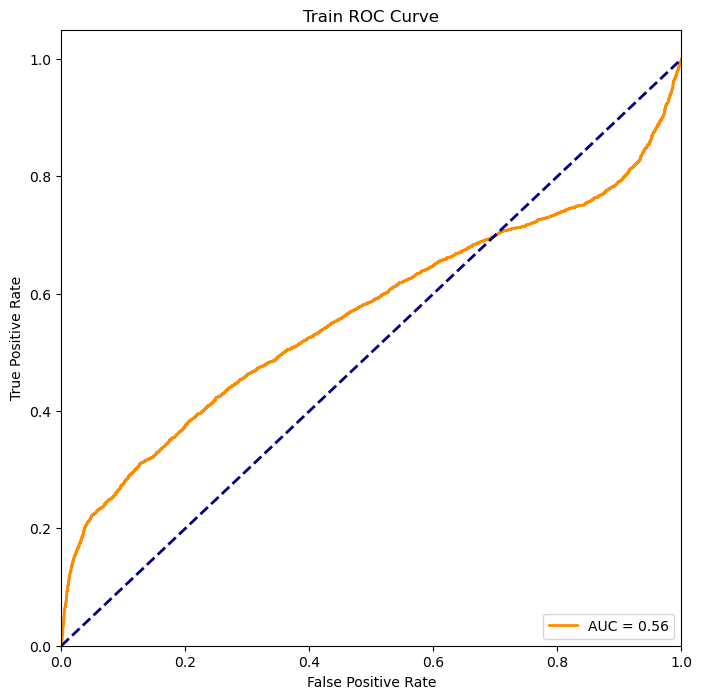

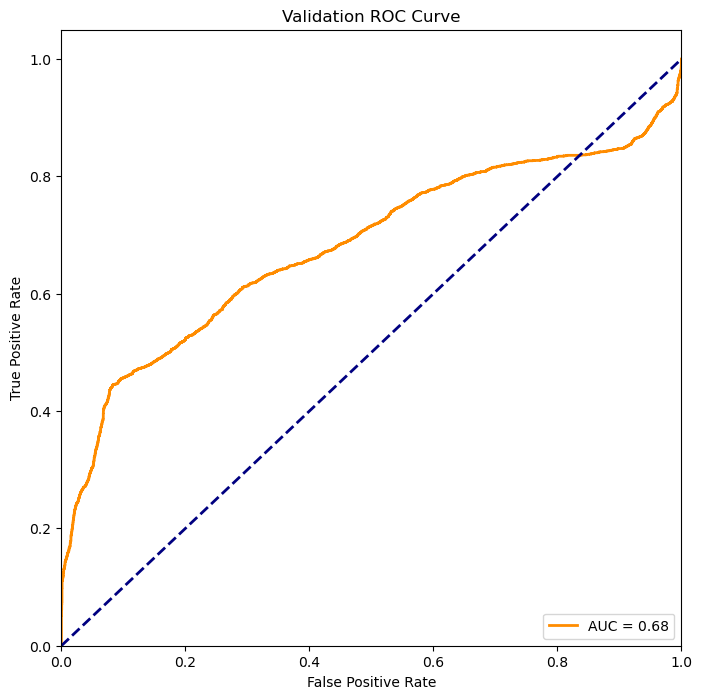

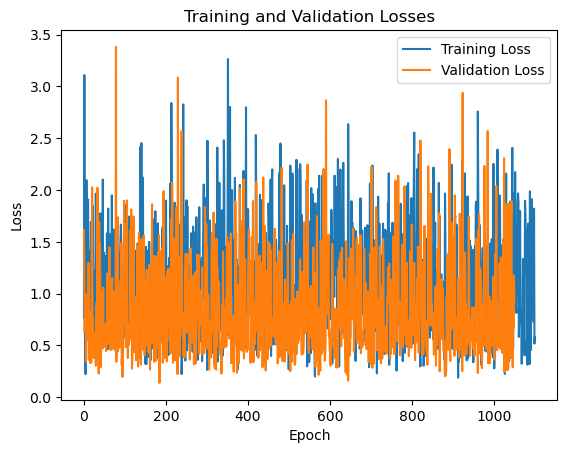

In [10]:
# Compute ROC-AUC and plot ROC curve
train_auc = roc_auc_score(train_labels, train_preds)
val_auc = roc_auc_score(val_labels, val_preds)

fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_preds)

plot_roc_curve(fpr_train, tpr_train, train_auc, title='Train ROC Curve')
plot_roc_curve(fpr_val, tpr_val, val_auc, title='Validation ROC Curve')

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
#Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html